In [18]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
from naplab.frame_data import read_timestamps
from naplab.gps import process_gps_data
from utils import plot_coordinates
from interpolate import GPSPointDataset, train_model, predict, device, CoordinatePredictionModel
import torch.optim as optim
import torch
from torch.optim.lr_scheduler import StepLR
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
# load training data
# Train the model
gps_left = process_gps_data("./Trip094/gnss094_50.txt")
gps_right = process_gps_data("./Trip094/gnss094_52.txt")

train_dataset = GPSPointDataset(gps_left)
testdata = train_dataset.pop(60)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=len(train_dataset.data),
    shuffle=True,
    pin_memory=True,
)

Epoch 4400, Train Loss: 0.00126490, Train RMSE: 0.03556538, Best RMSE: 0.03397159, Optimizer LR: [0.009569328906720125]


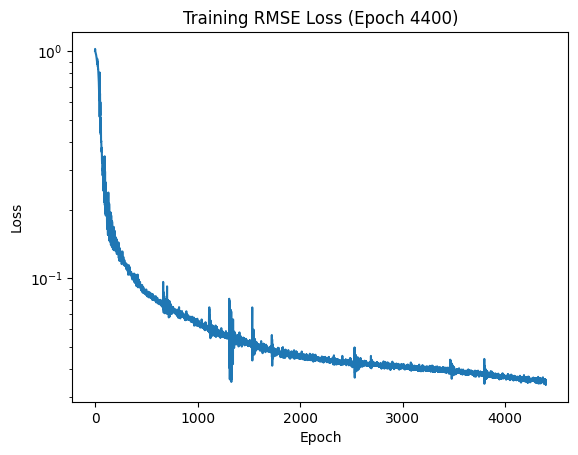

  1%|▏         | 4478/300000 [01:40<1:49:54, 44.81it/s]

In [20]:
# TRAINING CUSTOM MODEL

input_dim = 1  # Dimensionality of input timestamps
output_dim = 3  # Dimensionality of XYZ coordinates
hidden_dim = 128
num_epochs = 300000

model2 = CoordinatePredictionModel(input_dim, hidden_dim, output_dim=output_dim)
optimizer = optim.AdamW(model2.parameters(), lr=.01)
scheduler = StepLR(optimizer, step_size=100, gamma=0.999)

train_model(model2, train_loader, optimizer, scheduler, num_epochs)


In [ ]:
input_dim = 1  # Dimensionality of input timestamps
output_dim = 3  # Dimensionality of XYZ coordinates
hidden_dim = 128

model2 = CoordinatePredictionModel(input_dim, hidden_dim, output_dim=output_dim)
model2.load_state_dict(torch.load("./models/best_model.pth"))
model2.eval()

CoordinatePredictionModel(
  (model): Sequential(
    (0): Linear(in_features=1, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=3, bias=True)
  )
)

In [ ]:
# Example usage of inference
timestamp = torch.tensor([[testdata.timestamp]], dtype=torch.float32).to(device)  # Example timestamp in microseconds
predicted_xyz = predict(model2, timestamp)
denormed_predicted_xyz = train_dataset.denormalize_position(predicted_xyz.numpy())[0]
denormed_testdata_xyz = train_dataset.denormalize_position(testdata.position)

print("Predicted XYZ coordinates:", predicted_xyz, "Actual XYZ coordinates:", testdata.position)
print("Denormalized Predicted XYZ coordinates:", denormed_predicted_xyz, "Denormalized Actual XYZ coordinates:", denormed_testdata_xyz)


Predicted XYZ coordinates: tensor([[-1.3699,  0.5760, -0.8915]]) Actual XYZ coordinates: [-1.39101364  0.62990097 -0.90112031]
Denormalized Predicted XYZ coordinates: [2.70455531e+05 7.04000799e+06 6.66077948e+01] Denormalized Actual XYZ coordinates: [2.70453382e+05 7.04001209e+06 6.65800000e+01]


Number of GPS points:  100 Number of timestamps:  300


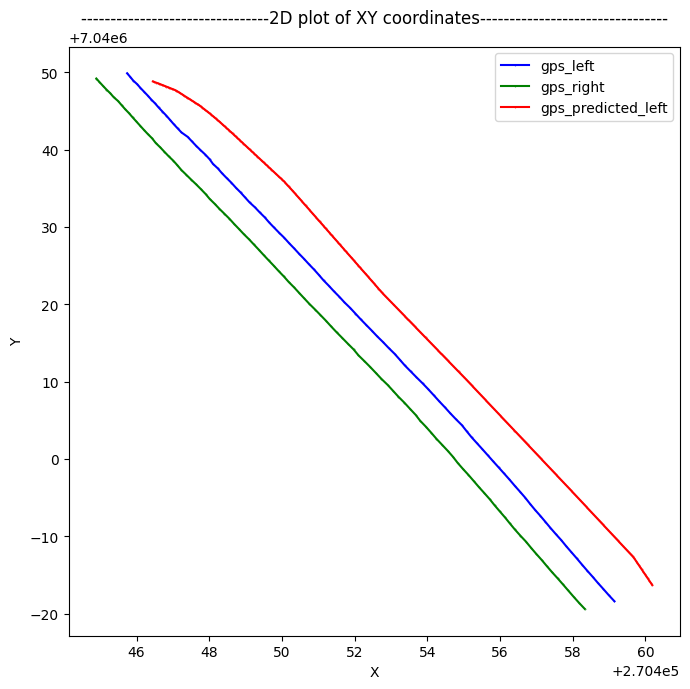

In [ ]:

max_gps = 100
# timestamps based on C5_R1 video
timestamps = read_timestamps("./Trip094/C5_R1.h264.timestamps")
max_ts = max_gps * 3 if max_gps != -1 else -1

print("Number of GPS points: ", max_gps, "Number of timestamps: ", max_ts)

norm_t = np.array([train_dataset.normalize_1_timestamp(timestamp) for timestamp in timestamps[:max_ts]]).reshape(-1, 1)
pred_pos = predict(model2, torch.tensor(norm_t, dtype=torch.float32).to(device))
predicted_gps_left = train_dataset.denormalize_position(pred_pos.numpy())

gps_left_pos = [point.position for point in gps_left[:max_gps]]
gps_right_pos = [point.position for point in gps_right[:max_gps]]

plot_coordinates([gps_left_pos, gps_right_pos, predicted_gps_left],
        labels=["gps_left", "gps_right", "gps_predicted_left"], figsize=(7, 7), is3D=False)